In [1]:
import os
import time
import subprocess
import json
from concurrent.futures import ProcessPoolExecutor

import numpy as np
import SimpleITK as sitk

import utils

from networks import deformable

/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
### Identity - to create results without any registration (useful for creating the baseline)
# output_path = None # TO DEFINE
# dhr_params = dict()
# dhr_params['segmentation_mode'] = "deep_segmentation"
# dhr_params['initial_rotation'] = False
# dhr_params['affine_registration'] = False
# dhr_params['nonrigid_registration'] = False
# segmentation_params = dict()
# segmentation_params['model_path'] =  None # Path to segmentation model
# dhr_params['segmentation_params'] = segmentation_params
# load_masks = False
###

### Seg + Rotation Params - to create results from the initial rotation (useful for creating the affine training dataset)
# output_path = None # TO DEFINE
# dhr_params = dict()
# dhr_params['segmentation_mode'] = "deep_segmentation"
# dhr_params['initial_rotation'] = True
# dhr_params['affine_registration'] = False
# dhr_params['nonrigid_registration'] = False
# initial_rotation_params = dict()
# initial_rotation_params['angle_step'] = 1
# dhr_params['initial_rotation_params'] = initial_rotation_params
# segmentation_params = dict()
# segmentation_params['model_path'] =  None # Path to segmentation model
# dhr_params['segmentation_params'] = segmentation_params
# load_masks = False
###

## Seg + Rotation Params + Affine - to create results from the initial rotation + affine registration (useful for creating the nonrigid training dataset)
# STEP 1
# dataset_path = "/data/ANHIR_Parsed_1024_Masks"
# output_path = "/data/ANHIR_Out_Aff_1024_Masks_TRANSFORMED"
# dhr_params = dict()
# dhr_params["segmentation_mode"] = None  # or "deep_segmentation"
# dhr_params["initial_rotation"] = False
# dhr_params["affine_registration"] = True
# dhr_params["nonrigid_registration"] = False
# initial_rotation_params = dict()
# initial_rotation_params["angle_step"] = 1
# dhr_params["initial_rotation_params"] = initial_rotation_params
# affine_registration_params = dict()
# models_path = paths.models_path
# affine_registration_params["model_path"] = "/data/outdoor_megadepth.ckpt"
# affine_registration_params[
#     "main_config_path"
# ] = "./networks/feature_matching/configs/loftr/outdoor/loftr_ds_quadtree.py"
# affine_registration_params["affine_type"] = "quadtree"
# affine_registration_params["resize"] = False
# dhr_params["affine_registration_params"] = affine_registration_params
# segmentation_params = dict()
# segmentation_params["model_path"] = None  # Path to segmentation model
# dhr_params["segmentation_params"] = segmentation_params
# load_masks = True
##

# STEP 2 (only deformable)
dataset_path = "/data/ANHIR_Out_Aff_1024_Masks_TRANSFORMED"
output_path = "/data/ANHIR_Out_Aff_1024_Masks_TRANSFORMED_DEFORMABLE_EXP03"
dhr_params = dict()
dhr_params["segmentation_mode"] = None  # or "deep_segmentation"
dhr_params["initial_rotation"] = False
dhr_params["affine_registration"] = False
dhr_params["nonrigid_registration"] = True
initial_rotation_params = dict()
initial_rotation_params["angle_step"] = 1
dhr_params["initial_rotation_params"] = initial_rotation_params
# affine_registration_params = dict()
# models_path = paths.models_path
# affine_registration_params["model_path"] = "/data/outdoor_megadepth.ckpt"
# affine_registration_params[
#     "main_config_path"
# ] = "./networks/feature_matching/configs/loftr/outdoor/loftr_ds_quadtree.py"
# affine_registration_params["affine_type"] = "quadtree"
# affine_registration_params["resize"] = False
nonrigid_registration_params = dict()  # Params used during training
nonrigid_registration_params["model"] = "dfbr"
dhr_params["nonrigid_registration_params"] = nonrigid_registration_params
# dhr_params["affine_registration_params"] = affine_registration_params
# segmentation_params = dict()
# segmentation_params["model_path"] = None  # Path to segmentation model
# dhr_params["segmentation_params"] = segmentation_params
load_masks = True

# ### Seg + Rotation Params + Affine + Nonrigid - to create final nonrigid results
# output_path = None # TO DEFINE
# dhr_params = dict()
# dhr_params['segmentation_mode'] = "deep_segmentation"
# dhr_params['initial_rotation'] = True
# dhr_params['affine_registration'] = True
# dhr_params['nonrigid_registration'] = True
# initial_rotation_params = dict()
# initial_rotation_params['angle_step'] = 1
# dhr_params['initial_rotation_params'] = initial_rotation_params
# affine_registration_params = dict()
# models_path = None # TO DEFINE
# affine_registration_params['model_path'] = None # TO DEFINE
# affine_registration_params['affine_type'] = "simple"
# dhr_params['affine_registration_params'] = affine_registration_params
# nonrigid_registration_params = dict() # Params used during training
# nonrigid_registration_params['stride'] = 128
# nonrigid_registration_params['patch_size'] = (256, 256)
# nonrigid_registration_params['number_of_patches'] = 32
# nonrigid_registration_params['num_levels'] = 3
# nonrigid_registration_params['inner_iterations_per_level'] = [3, 3, 3]
# nonrigid_registration_params['model_path'] = None # TO DEFINE
# dhr_params['nonrigid_registration_params'] = nonrigid_registration_params
# segmentation_params = dict()
# segmentation_params['model_path'] =  None # TO DEFINE
# dhr_params['segmentation_params'] = segmentation_params
# load_masks = False
# ###

In [3]:
def register(current_id):
    import torch

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    b_loading = time.time()
    current_pair = str(current_id)
    current_pair_dir = os.path.join(output_path, str(current_id))
    if os.path.exists(current_pair_dir):
        print(
            "Directory for current pair {} already exists. Skipping registration.".format(
                current_id
            )
        )
        return
    if load_masks:
        (
            source,
            target,
            source_landmarks,
            target_landmarks,
            status,
            source_mask,
            target_mask,
        ) = utils.load_pair_registered(
            current_pair, dataset_path, load_masks=load_masks
        )
    else:
        (
            source,
            target,
            source_landmarks,
            target_landmarks,
            status,
        ) = utils.load_pair_registered(
            current_pair, dataset_path, load_masks=load_masks
        )
    print("Current pair: ", current_pair)
    print("Status: ", status)

    e_loading = time.time()
    loading_time = e_loading - b_loading
    print("Time for loading and memory transfer: ", loading_time)
    b_registration = time.time()

    try:
        displacement_field = deformable.register(
            source, target, source_mask, target_mask
        )
    except Exception as e:
        print(e)
        displacement_field = torch.zeros(
            (source.shape[0], source.shape[1], 2), dtype=torch.float32
        )

    source = torch.from_numpy(source).to(device)
    target = torch.from_numpy(target).to(device)

    transformed_target = utils.warp_tensor(target, displacement_field, device=device)

    transformed_source_landmarks = utils.transform_landmarks(
        source_landmarks, displacement_field
    )

    e_registration = time.time()
    registration_time = e_registration - b_registration
    print("Time for registration: ", registration_time)

    source_save_path = os.path.join(output_path, current_pair, "source.mha")
    target_save_path = os.path.join(output_path, current_pair, "target.mha")
    transformed_target_save_path = os.path.join(
        output_path, current_pair, "transformed_target.mha"
    )
    source_landmarks_path = os.path.join(
        output_path, current_pair, "source_landmarks.csv"
    )
    transformed_source_landmarks_path = os.path.join(
        output_path, current_pair, "transformed_source_landmarks.csv"
    )
    if status == "training":
        target_landmarks_path = os.path.join(
            output_path, current_pair, "target_landmarks.csv"
        )

    if not os.path.isdir(os.path.dirname(source_save_path)):
        os.makedirs(os.path.dirname(source_save_path))

    sitk.WriteImage(sitk.GetImageFromArray(source.cpu().numpy()), source_save_path)
    sitk.WriteImage(sitk.GetImageFromArray(target.cpu().numpy()), target_save_path)
    sitk.WriteImage(
        sitk.GetImageFromArray(transformed_target.cpu().numpy()),
        transformed_target_save_path,
    )
    utils.save_landmarks(source_landmarks, source_landmarks_path)
    utils.save_landmarks(
        transformed_source_landmarks, transformed_source_landmarks_path
    )

    if status == "training":
        utils.save_landmarks(target_landmarks, target_landmarks_path)
        try:
            image_diagonal = np.sqrt(source.shape[0] ** 2 + source.shape[1] ** 2)
            rtre_initial = utils.calculate_rtre(
                source_landmarks, target_landmarks, image_diagonal
            )
            rtre_final = utils.calculate_rtre(
                transformed_source_landmarks, target_landmarks, image_diagonal
            )
            string_to_save = (
                "Initial TRE: "
                + str(np.median(rtre_initial))
                + "\n"
                + "Resulting TRE: "
                + str(np.median(rtre_final))
            )
            txt_path = os.path.join(output_path, current_pair, "tre.txt")
            with open(txt_path, "w") as file:
                file.write(string_to_save)
        except:
            pass
    time_to_save = str(registration_time + loading_time)
    time_txt_path = os.path.join(output_path, current_pair, "time.txt")
    with open(time_txt_path, "w") as file:
        file.write(time_to_save)


def run_script(current_id):
    args_str = json.dumps(args)

    process = subprocess.run(
        [
            "nice",
            "-n",
            "10",
            "python",
            "register_deformable.py",
            str(current_id),
            args_str,
        ]
    )


def run(ids):
    num_processes = 6  # Adjust based on system resources
    with ProcessPoolExecutor(max_workers=num_processes) as executor:
        for _ in executor.map(run_script, ids):
            pass

In [4]:
args = {
    "dataset_path": dataset_path,
    "output_path": output_path,
    "load_masks": load_masks,
}

ids_list = range(0,481)

In [5]:
run(ids_list)

Current pair:  1
Status:  evaluation
Time for loading and memory transfer:  0.012547492980957031
Current pair:  0
Status:  evaluation
Time for loading and memory transfer:  0.015341758728027344
Current pair: Current pair:   54

Status: Status:   trainingtraining

Time for loading and memory transfer:  Time for loading and memory transfer:  0.017367601394653320.017390012741088867

Current pair:  2
Status:  evaluation
Time for loading and memory transfer:  0.017061948776245117
Current pair:  3
Status:  evaluation
Time for loading and memory transfer:  0.01787710189819336


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  24.35227370262146
Current pair:  6
Status:  training
Time for loading and memory transfer:  0.06125664710998535


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  31.136536836624146


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  33.38449311256409
Current pair:  7
Status:  training
Time for loading and memory transfer:  0.03179526329040527


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  35.45504832267761
Current pair:  8
Status:  training
Time for loading and memory transfer:  0.030834674835205078
Current pair:  9
Status:  evaluation
Time for loading and memory transfer:  0.03376150131225586


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  39.231212854385376
Time for registration:  39.20592951774597
Current pair:  10
Status:  evaluation
Time for loading and memory transfer:  0.038999319076538086
Current pair:  11
Status:  evaluation
Time for loading and memory transfer:  0.046404123306274414


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  32.10490703582764
Current pair:  12
Status:  evaluation
Time for loading and memory transfer:  0.17312216758728027


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  31.626995086669922
Time for registration:  35.39812207221985


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  37.87932372093201
Current pair:  13
Status:  training
Time for loading and memory transfer:  0.04955172538757324
Current pair:  14
Status:  evaluation
Time for loading and memory transfer:  0.07593846321105957
Current pair:  15
Status:  evaluation
Time for loading and memory transfer:  0.056925296783447266


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  36.05054473876953
Current pair:  16
Status:  evaluation
Time for loading and memory transfer:  0.07604575157165527


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  68.10519623756409
Current pair:  17
Status:  evaluation
Time for loading and memory transfer:  0.06183886528015137


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  39.48401188850403


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  34.71477770805359
Current pair:  18
Status:  training
Time for loading and memory transfer:  0.05041050910949707
Current pair:  19
Status:  training
Time for loading and memory transfer:  0.07117223739624023


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  40.78103184700012
Current pair:  20
Status:  training
Time for loading and memory transfer:  0.06425690650939941


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  47.01118040084839
Current pair:  21
Status:  training
Time for loading and memory transfer:  0.0567934513092041


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  46.21711802482605
Current pair:  22
Status:  training
Time for loading and memory transfer:  0.06403756141662598


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  25.964234352111816
Current pair:  23
Status:  evaluation
Time for loading and memory transfer:  0.05923748016357422


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  31.33941078186035
Current pair:  24
Status:  evaluation
Time for loading and memory transfer:  0.08690571784973145


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  38.02614760398865
Time for registration:  33.50017166137695


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  59.78539490699768
Current pair:  25
Status:  evaluation
Time for loading and memory transfer:  0.06459331512451172
Current pair:  26
Status:  evaluation
Time for loading and memory transfer:  0.0652155876159668
Current pair:  27
Status:  training
Time for loading and memory transfer:  0.062044382095336914


/home/ivan/miniconda3/envs/imgreg/lib/python3.8/site-packages/torch/nn/functional.py:3828: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


Time for registration:  34.09010362625122
Current pair:  28
Status:  evaluation
Time for loading and memory transfer:  0.0777435302734375


In [10]:
def find_missing_ids(output_dir, id_range):
    # getting all directories in the output directory
    dir_list = os.listdir(output_dir)

    # creating list of missing ids
    missing_ids = [
        str(directory) for directory in id_range if str(directory) not in dir_list
    ]

    return missing_ids

In [12]:
# output_dir = "/data/ANHIR_Out_Aff_1024_Masks_TRANSFORMED_DEFORMABLE_EXP02"
id_range = range(0, 480)
find_missing_ids(output_path, id_range)


[]

In [1]:
import pandas as pd
import json

data = json.load(open('./eval_exp_02.json'))['aggregates']

# Initialize empty dictionary to hold the results
results = {}

for key, value in data.items():
    parts = key.split('__')
    if len(parts) == 3:
        metric, tissue, _ = parts
        metric_parts = metric.split("-")
        stat = metric_parts[0]
        operation = metric_parts[1]
        
        if tissue not in results:
            results[tissue] = {}
        
        if operation not in results[tissue]:
            results[tissue][operation] = {}

        results[tissue][operation][stat] = value

# Convert the results dictionary to DataFrame
df = pd.concat({k: pd.DataFrame(v).T for k, v in results.items()}, axis=0)

print(df)

                                   Median   Average
tissue_COAD          Max         0.030106  0.046199
                     Robustness  0.987952  0.954726
                     Median      0.006297  0.017191
                     Average     0.008077  0.018853
tissue_breast        Max         0.047578  0.180325
                     Robustness  1.000000  0.860371
                     Median      0.019582  0.106042
                     Average     0.023428  0.104692
tissue_kidney        Max         0.021274  0.031668
                     Robustness  0.975920  0.854819
                     Median      0.004048  0.013835
                     Average     0.004982  0.015287
tissue_gastric       Max         0.044151  0.146253
                     Robustness  1.000000  0.924803
                     Median      0.026020  0.084467
                     Average     0.026735  0.085390
tissue_lung-lobes    Max              NaN       NaN
                     Robustness       NaN       NaN
            

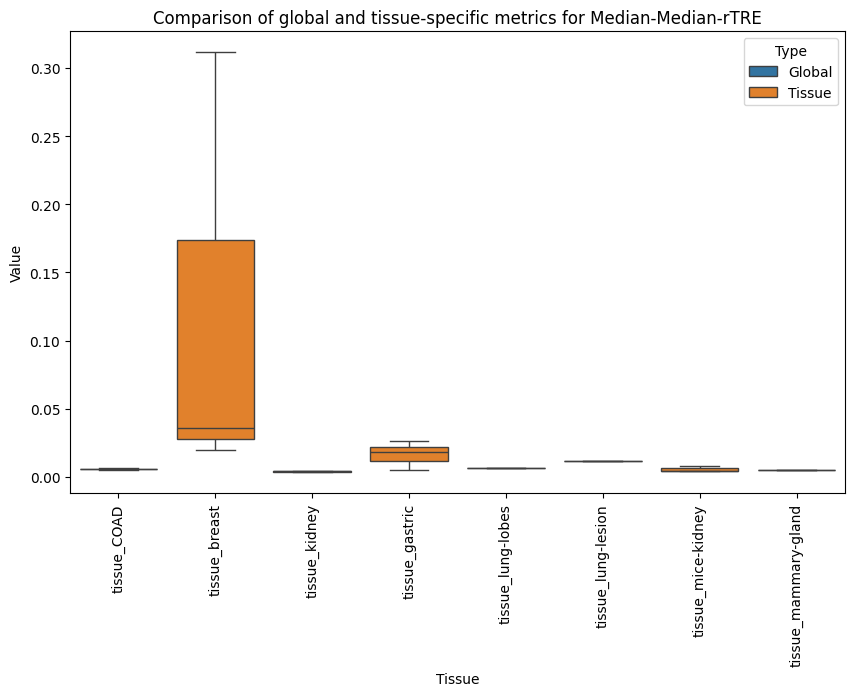

In [9]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load data from JSON
data = json.load(open('./eval_exp_01.json'))['aggregates']

# separate global and tissue-specific metrics
global_metrics = {k: v for k, v in data.items() if "__" not in k}
tissue_metrics = {k: v for k, v in data.items() if "__" in k}

# convert to dataframes
global_df = pd.DataFrame(list(global_metrics.items()), columns=['Metric', 'Value'])
global_df['Type'] = 'Global'

tissue_df = pd.DataFrame(list(tissue_metrics.items()), columns=['Metric', 'Value'])

# Parse tissue metrics to obtain the clean metric name and tissue
tissue_df[['Metric','Tissue']] = tissue_df['Metric'].str.split("__",expand=True)[[0,1]]
tissue_df['Type'] = 'Tissue'

# Merge the metric dataframes
combined_df = pd.concat([global_df, tissue_df], ignore_index=True)

# Select a metric for comparison
metric = 'Median-Median-rTRE'

# Filter combined dataframe by the selected metric
filtered_df = combined_df[combined_df['Metric'] == metric]

# Plot box and whiskers
plt.figure(figsize=(10, 6))
sns.boxplot(x='Tissue', y='Value', hue='Type', data=filtered_df)

plt.title('Comparison of global and tissue-specific metrics for '+metric)
plt.xticks(rotation=90)
plt.show()
